In [1]:
# Importing libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


In [2]:
# Loading the data
data = pd.read_csv("housing.csv")

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
print("columns::", data.columns.tolist())

columns:: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [5]:
# filling missing data with `0`.
data.fillna(value=0, inplace=True)

In [6]:
data['median_house_value'] = np.log1p(data['median_house_value'])

In [7]:
# split the data into training/validation and test datasets in ratio 60:20:20.
df_full, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=1)

In [8]:
y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']


# delete the `median_house_value` from data
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [9]:
train_dict = df_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [10]:
# Vectorization
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

Question 1
---

Which feature is used for splitting the data?

- ocean_proximity=INLAND
- total_rooms
- latitude
- population

In [11]:
dt_reg = DecisionTreeRegressor(max_depth=1)
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt_reg, feature_names=dv.get_feature_names_out().tolist()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Question 2
--- 
What's the RMSE of this model on validation?

- 0.05
- 0.25
- 0.55
- 0.85

In [13]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=10, 
                            random_state=1,
                            n_jobs=-1)

rf_reg.fit(X_train, y_train)
y_preds = rf_reg.predict(X_val)

result = mean_squared_error(y_val, y_preds)
print("RMSE:: %.2f" % np.sqrt(result))

RMSE:: 0.25


Question 3
---
After which value of n_estimators does RMSE stop improving?

- 10
- 50
- 70
- 150

In [14]:
# Question 3 - solution

rmses = []
for n in range(10, 201, 10):
    model = RandomForestRegressor(n_estimators=n, 
                                random_state=1)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, y_preds)
    rmses.append((n, np.sqrt(mse)))

scores = pd.DataFrame(rmses, columns=['n_estimators', 'rmse'])

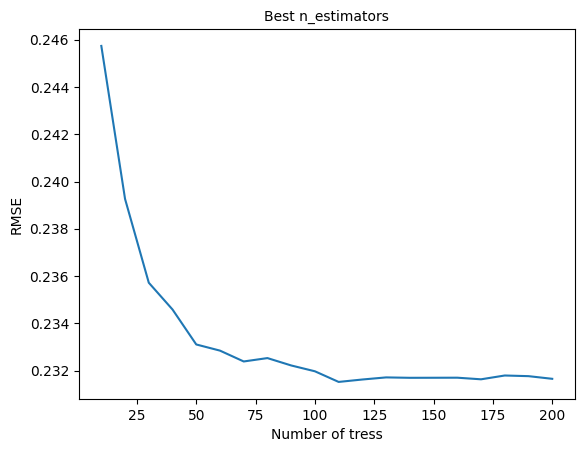

In [15]:
plt.plot(scores.n_estimators, scores.rmse)
plt.xlabel("Number of tress")
plt.ylabel("RMSE")
plt.title("Best n_estimators", size=10)
plt.show()

Question 4
---
What's the best max_depth:

- 10
- 15
- 20
- 25

In [16]:
rmse = []
max_depths = [10, 15, 20, 25]
for depth in max_depths:
    for n in range(10, 201, 10):
        model = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_val)
        mse = mean_squared_error(y_val, y_preds)
        
        rmse.append((n, depth, np.sqrt(mse)))


scores = pd.DataFrame(data=rmse, columns=['n_estimators', 'max_depth', 'RMSE'])

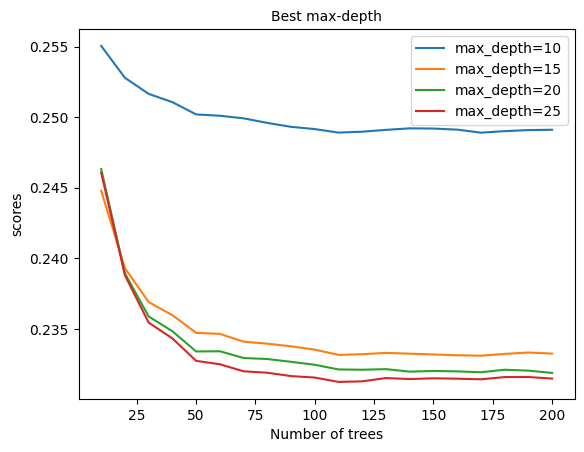

In [17]:
# Data preparation
grps = scores.groupby('max_depth')
for max_depth in max_depths:
    depth_grp = grps.get_group(max_depth)
    plt.plot(depth_grp.n_estimators, depth_grp.RMSE, label='max_depth=%d' %max_depth)
    plt.xlabel("Number of trees")
    plt.ylabel("scores")
    plt.title("Best max-depth", size=10)
    plt.legend()

Question 5
---
What's the most important feature?

- total_rooms
- median_income
- total_bedrooms
- longitude

In [18]:
# Radnom Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=10, 
                                max_depth=20,
                                random_state=1,
                                n_jobs=-1)

rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

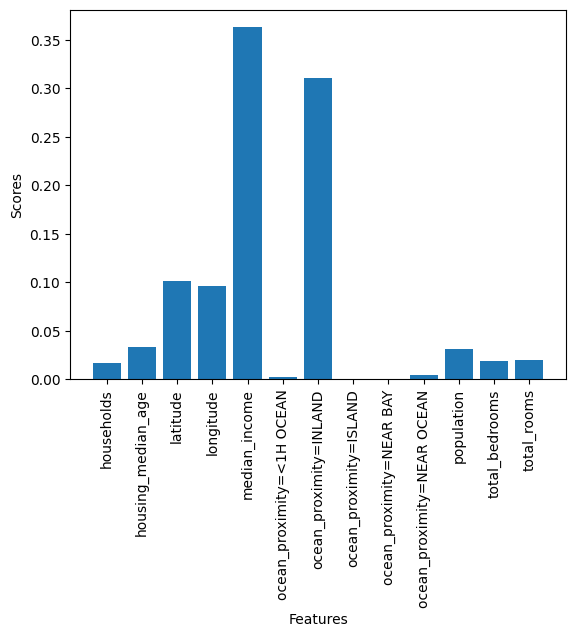

In [19]:
# Feature important scores
feature_names = dv.get_feature_names_out().tolist()
feature_scores = rf_reg.feature_importances_
plt.bar(feature_names, feature_scores)

plt.xlabel("Features")
plt.ylabel("Scores")
plt.xticks(rotation=90)
plt.show()

Question 6
---
Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both gives same

In [20]:
# XGBoost Regressor
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [21]:
# function to parse the output from xgboost regressor.
def parse_xgb_output(output, eta=0.3):
    results = []
    for line in output.stdout.strip().split('\n'):
        n, train_rmse, val_rmse = line.split('\t')
        n = int(n.strip('[]'))
        train_score = float(train_rmse.split(':')[1])
        val_score = float(val_rmse.split(':')[1])
        
        results.append((n, train_score, val_score))

    scores = pd.DataFrame(results, columns=['n', 'train_rmse', 'val_rmse'])
    scores['eta'] = eta
    return scores


In [22]:
%%capture output
xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,  
                    dtrain, 
                    num_boost_round=100, 
                    evals=watchlist)

In [23]:
# for eta==0.3
df_score1 = parse_xgb_output(output)

In [24]:
%%capture output
xgb_params = {
    'eta': 0.1,
    'max_depth': 6, 
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,  
                    dtrain, 
                    num_boost_round=100, 
                    evals=watchlist)

In [25]:
# for eta == 0.1
df_score2 = parse_xgb_output(output, eta=0.1)

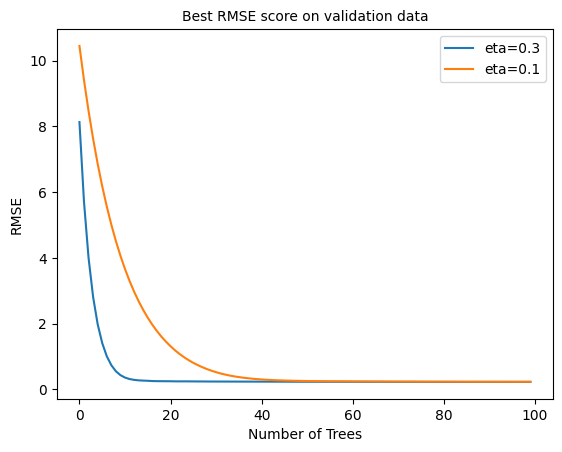

In [26]:
plt.plot(df_score1.n, df_score1.val_rmse, label='eta=0.3')
plt.plot(df_score2.n, df_score2.val_rmse, label='eta=0.1')

plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Best RMSE score on validation data", size=10)

plt.legend()
plt.show()